In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('./snli_1.0/snli_1.0_train.txt', sep='\t')
dev = pd.read_csv('./snli_1.0/snli_1.0_dev.txt', sep='\t')
test = pd.read_csv('./snli_1.0/snli_1.0_test.txt', sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: './snli_1.0/snli_1.0_train.txt'

In [9]:
train['sentence1_len'] = train.sentence1.apply(lambda x: len(x.split(' ')))
train['sentence2_len'] = train.sentence2.apply(lambda x: len(str(x).split(' ')))

dev['sentence1_len'] = train.sentence1.apply(lambda x: len(x.split(' ')))
dev['sentence2_len'] = train.sentence2.apply(lambda x: len(str(x).split(' ')))

test['sentence1_len'] = train.sentence1.apply(lambda x: len(x.split(' ')))
test['sentence2_len'] = train.sentence2.apply(lambda x: len(str(x).split(' ')))

## Train sentence lengths

<AxesSubplot:xlabel='gold_label', ylabel='sentence2_len'>

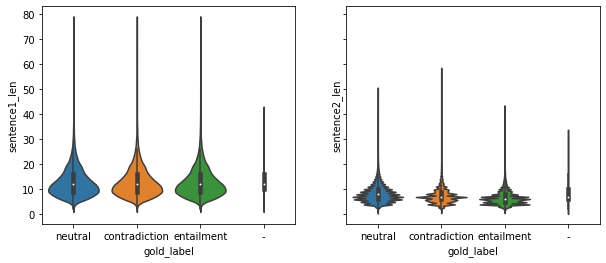

In [43]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

sns.violinplot(x="gold_label", y="sentence1_len", data=train, scale='count', scale_hue=False, ax=axes[0])
sns.violinplot(x="gold_label", y="sentence2_len", data=train, scale='count', scale_hue=False, ax=axes[1])


## dev sentence lengths

<AxesSubplot:xlabel='gold_label', ylabel='sentence2_len'>

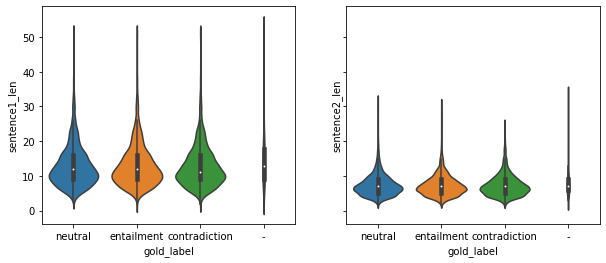

In [44]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

sns.violinplot(x="gold_label", y="sentence1_len", data=dev, scale='count', scale_hue=False, ax=axes[0])
sns.violinplot(x="gold_label", y="sentence2_len", data=dev, scale='count', scale_hue=False, ax=axes[1])

## test sentence lengths

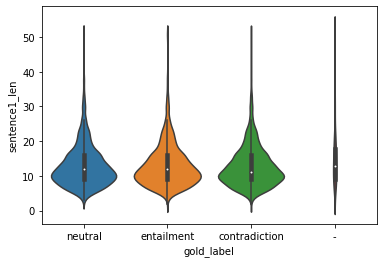

In [35]:
ax = sns.violinplot(x="gold_label", y="sentence1_len", data=dev, scale='count', scale_hue=False)


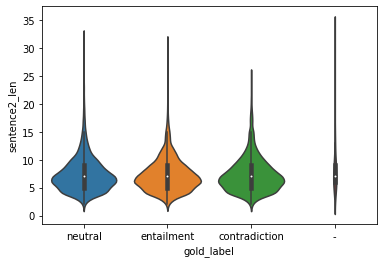

In [37]:
ax = sns.violinplot(x="gold_label", y="sentence2_len", data=dev, scale='count', scale_hue=False)


In [ ]:
ax = sns.violinplot(x="gold_label", y="sentence2_len", data=dev, scale='count', scale_hue=False)


In [26]:
test[test.gold_label == '-']

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5,sentence1_len,sentence2_len
46,-,( ( During ( calf roping ) ) ( ( a cowboy ) ( ...,( ( Cowboy ( ( falling off ) horse ) ) . ),(ROOT (S (PP (IN During) (NP (NN calf) (NN rop...,(ROOT (S (VP (ADVP (RB Cowboy)) (VBG falling) ...,During calf roping a cowboy calls off his horse.,Cowboy falling off horse.,2972268289.jpg#4,2972268289.jpg#4r1e,entailment,contradiction,entailment,contradiction,neutral,10,12
107,-,( ( A ( Ford car ) ) ( ( is ( ( making ( a ( r...,( ( ( A car ) ( ( proceeding straight ) ( as p...,(ROOT (S (NP (DT A) (NNP Ford) (NN car)) (VP (...,(ROOT (S (NP (NP (DT A) (NN car)) (VP (VBG pro...,A Ford car is making a right turn as 3 males a...,A car proceeding straight as pedestrians walke...,4114589329.jpg#0,4114589329.jpg#0r1c,contradiction,neutral,entailment,contradiction,entailment,7,7
124,-,( ( An ( old woman ) ) ( ( watches ( ( a man )...,( ( A ( gray ( haired person ) ) ) ( ( is ( lo...,(ROOT (S (NP (DT An) (JJ old) (NN woman)) (VP ...,(ROOT (S (NP (DT A) (JJ gray) (JJ haired) (NN ...,An old woman watches a man look down at some b...,A gray haired person is looking at a gentleman.,4926115712.jpg#1,4926115712.jpg#1r1e,entailment,neutral,neutral,entailment,contradiction,6,9
201,-,( ( A bird ) ( ( is ( ( flapping ( its wings )...,( ( The bird ) ( ( is ( floating ( on ( the wa...,(ROOT (S (NP (DT A) (NN bird)) (VP (VBZ is) (V...,(ROOT (S (NP (DT The) (NN bird)) (VP (VBZ is) ...,A bird is flapping its wings on the water.,The bird is floating on the water.,3335501468.jpg#2,3335501468.jpg#2r1e,entailment,contradiction,neutral,neutral,contradiction,7,9
371,-,( ( Young woman ) ( ( is ( ( putting ( her clo...,( ( A ( tall person ) ) ( drying clothes ) ),(ROOT (S (NP (NNP Young) (NN woman)) (VP (VBZ ...,(ROOT (S (NP (NP (DT A) (JJ tall) (NN person))...,Young woman is putting her clothes in the drye...,A tall person drying clothes,4702657446.jpg#0,4702657446.jpg#0r1n,neutral,neutral,entailment,contradiction,entailment,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,-,( ( A man ) ( ( is ( ( standing ( in ( front (...,( ( The man ) ( ( is ( in ( a church ) ) ) . ) ),(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,(ROOT (S (NP (DT The) (NN man)) (VP (VBZ is) (...,A man is standing in front of a temple while w...,The man is in a church.,4948237706.jpg#1,4948237706.jpg#1r1c,contradiction,neutral,contradiction,entailment,entailment,14,8
9611,-,( ( A ( lab dog ) ) ( ( is ( standing ( on ( (...,( ( the animal ) ( ( ( is ( more inteligent ) ...,(ROOT (S (NP (DT A) (NN lab) (NN dog)) (VP (VB...,(ROOT (S (NP (DT the) (NN animal)) (VP (VBZ is...,A lab dog is standing on a fallen tree trunk w...,the animal is more inteligent then the man in ...,359082432.jpg#2,359082432.jpg#2r1c,contradiction,neutral,neutral,entailment,contradiction,10,9
9690,-,( ( ( A ( young girl ) ) ( in ( a black ) ) ) ...,( ( The ( young girl ) ) ( is ( in ( a ( balle...,(ROOT (S (NP (NP (DT A) (JJ young) (NN girl)) ...,(ROOT (S (NP (DT The) (JJ young) (NN girl)) (V...,A young girl in a black leotard swinging on th...,The young girl is in a ballet class,4728873248.jpg#0,4728873248.jpg#0r1n,neutral,contradiction,entailment,neutral,contradiction,9,7
9723,-,( ( ( A surfer ) ( ( ( showing off ) ( his tal...,( ( A person ) ( ( is ( surfing ( on ( artific...,(ROOT (NP (NP (DT A) (NN surfer)) (VP (VBG sho...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A surfer showing off his talent in public usin...,A person is surfing on artificial waves.,6012829906.jpg#2,6012829906.jpg#2r1e,entailment,contradiction,entailment,neutral,neutral,9,6


In [46]:
# robustness to noise.. what if a turk labeler messed up?
len(train)

550152

In [47]:
from datasets import load_dataset

In [48]:
dataset = load_dataset('squad', split='train')

Reusing dataset squad (/home/eculbertson/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


In [49]:
pip install google-cloud-translate==2.0.1


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 90 kB 3.5 MB/s             
     |████████████████████████████████| 93 kB 3.0 MB/s             
     |████████████████████████████████| 152 kB 18.8 MB/s            
     |████████████████████████████████| 1.1 MB 20.1 MB/s            
     |████████████████████████████████| 198 kB 17.3 MB/s            
     |████████████████████████████████| 4.0 MB 19.3 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [50]:
from google.cloud import translate_v2


In [52]:

translate_client = translate_v2.Client()

DefaultCredentialsError: Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or explicitly create credentials and re-run the application. For more information, please see https://cloud.google.com/docs/authentication/getting-started

In [53]:
!  pip install googletrans

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 55 kB 2.8 MB/s             
     |████████████████████████████████| 42 kB 2.1 MB/s             
     |████████████████████████████████| 1.3 MB 7.5 MB/s            
     |████████████████████████████████| 53 kB 4.5 MB/s             
     |████████████████████████████████| 65 kB 8.5 MB/s             
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=3d19d0bbc258eaf145ef185ba64f2cf31a49d024beffbb4cd4abc9744ca3c9b1
  Stored in directory: /home/eculbertson/.cache/pip/wheels/0e/ce/9b/d51de1064911d42480ab6b57fc943ee36572441f27546354e2
Successfully built googletrans


In [5]:
import numpy as np


In [8]:
from googletrans import Translator
translator = Translator()

In [11]:
translator.translate('veritas lux mea', src='la').text

'veritas lux mea'

In [12]:
def backTranslate(translator, text, n_translates=1):
    translator = Translator()
    aug = text
    for i in range(n_translates):
        spanish = translator.translate(aug, src='en', dest='es').text
        print()
        aug = translator.translate(spanish, src='es', dest='en').text
    return aug

for i in range(2):
    train_idx = np.random.randint(0, high=len(train))
    source_text = train.sentence1.iloc[train_idx]
    print(train_idx)
    print('Original:', source_text)
    print('Single:  ', backTranslate(translator, source_text, 1))
    print('Double:  ', backTranslate(translator, source_text, 2))
    print('Triple:  ', backTranslate(translator, source_text, 3))
    print()

177289
Original: A group of men wearing suits standing with other people sitting, standing, and riding a bike.

Single:   A group of men wearing suits standing with other people sitting, standing, and riding a bike.


Double:   A group of men wearing suits standing with other people sitting, standing, and riding a bike.



Triple:   A group of men wearing suits standing with other people sitting, standing, and riding a bike.

3221
Original: A large, green, navigating wheel is held by an older man in a captain's hat and uniform.

Single:   A large, green, navigating wheel is held by an older man in a captain's hat and uniform.


Double:   A large, green, navigating wheel is held by an older man in a captain's hat and uniform.



Triple:   A large, green, navigating wheel is held by an older man in a captain's hat and uniform.



In [5]:
spanish.text

'Mi nombre es Eric'

In [10]:
train.sentence1.iloc[0]

'A person on a horse jumps over a broken down airplane.'

In [60]:
pip install googletrans==3.1.0a0


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=c98a6b5c4a5e28ac2813a06ab903cea3606eb4a7ee064fcf4f417562596e59ba
  Stored in directory: /home/eculbertson/.cache/pip/wheels/dd/59/af/8d6c96a719763990f1c548e36b17d9efdfb767f42f7ff39f53
Successfully built googletrans
  Attempting uninstall: googletrans
    Found existing installation: googletrans 3.0.0
    Uninstalling googletrans-3.0.0:
      Successfully uninstalled googletrans-3.0.0
Note: you may need to restart the kernel to use updated packages.


In [20]:
sum([len(x) for x in set(train.sentence1)])

9464940

In [23]:
sum([len(x) for x in set(map(str, train.sentence2))])

18903810

In [26]:
sum([len(x) for x in train.sentence2.value_counts().index])

18903807

In [27]:
18903810 + 9464940

28368750

In [28]:
28368750 / 500000 

56.7375

In [29]:
28368750 / 2000000

14.184375

In [30]:
500000 / 28368750

0.01762502753910553

In [31]:
0.017 * len(train)

9352.584

In [32]:
300 / 20

15.0

In [35]:
(1000000*15)  / 28368750 

0.5287508261731659

In [1]:
train[0]

NameError: name 'train' is not defined